<a href="https://colab.research.google.com/github/imr-framework/sequence_sharing_community/blob/main/offline_open_source_data_reconstruction/tutorials/google_colab/2_GRE2D_PICS_BART_Cartesian_undersampling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Offline Open-Source Data Reconstruction Tutorial
Reconstruct 2D GRE data with retrospective 2-fold Cartesian undersampling using BART

In [1]:
#@title SENSE reconstruction with BART - installation and compilation (about 2 min 30 sec)
# Just need to run this cell once.
%%bash
# Install BART's dependencies
apt-get install -y make gcc libfftw3-dev liblapacke-dev libpng-dev libopenblas-dev &> /dev/null

# Clone BART (delete previous version)
[ -d /content/bart ] && rm -r /content/bart
git clone https://github.com/mrirecon/bart/ bart &> /dev/null

cd bart
git checkout "v0.9.00"
# Configuration
COMPILE_SPECS=" PARALLEL=1
                OPENBLAS=1
                BLAS_THREADSAFE=1"

printf "%s\n" $COMPILE_SPECS > Makefiles/Makefile.local

# Compile BART
make &> /dev/null && echo ok

ok


Note: switching to 'v0.9.00'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by switching back to a branch.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -c with the switch command. Example:

  git switch -c <new-branch-name>

Or undo this operation with:

  git switch -

Turn off this advice by setting config variable advice.detachedHead to false

HEAD is now at 672a840f bump version


#### Setup Environment for BART

After downloading and compiling BART, the next step simplifies the handling of BART's command line interface inside an ipython jupyter notebook. We add the BART directory to the PATH variable and include the python wrapper for reading *.cfl files:

In [2]:
import sys, os
os.environ['BART_TOOLBOX_PATH'] = f"{os.getcwd()}/bart"
os.environ['PATH'] = os.environ['BART_TOOLBOX_PATH'] + ":" + os.environ['PATH']
sys.path.append(os.environ['BART_TOOLBOX_PATH'] + "/python/")
from bart import bart
import cfl
!wget https://raw.githubusercontent.com/pulseq/ISMRM-2025-Surfing-School-Hands-On-Open-Source-MR/main//offline_open_source_data_reconstruction/tutorials/example_data/gre2d_rawdata.mat
from scipy.io import loadmat
import numpy as np
import matplotlib.pyplot as plt

def imshow(x):
    x_array = cfl.readcfl(x)
    fig = plt.figure(figsize=(8, 5))
    plt.imshow(np.abs(x_array),cmap='gray')

def imshow_log(x):
    x_array = cfl.readcfl(x)
    fig = plt.figure(figsize=(8, 5))
    plt.imshow(np.log(np.abs(x_array)),cmap='gray')


--2025-05-07 14:02:18--  https://raw.githubusercontent.com/pulseq/ISMRM-2025-Surfing-School-Hands-On-Open-Source-MR/main//offline_open_source_data_reconstruction/tutorials/example_data/gre2d_rawdata.mat
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /pulseq/ISMRM-2025-Surfing-School-Hands-On-Open-Source-MR/main/offline_open_source_data_reconstruction/tutorials/example_data/gre2d_rawdata.mat [following]
--2025-05-07 14:02:18--  https://raw.githubusercontent.com/pulseq/ISMRM-2025-Surfing-School-Hands-On-Open-Source-MR/main/offline_open_source_data_reconstruction/tutorials/example_data/gre2d_rawdata.mat
Reusing existing connection to raw.githubusercontent.com:443.
HTTP request sent, awaiting response... 200 OK
Length: 7154110 (6.8M) [applicati

Text(0.5, 1.0, 'Root-Sum-of-Squares (RSS) image')

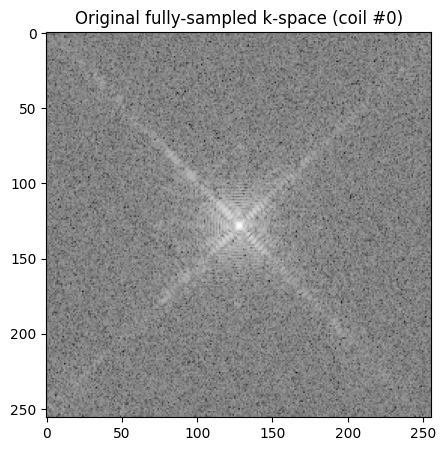

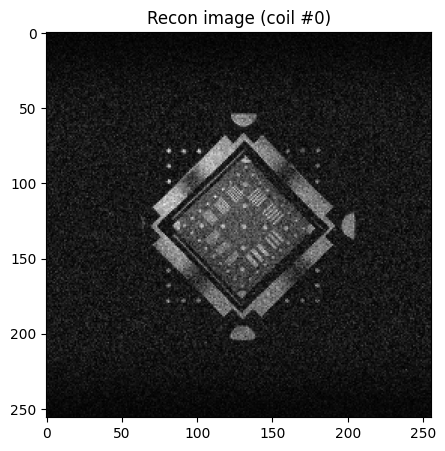

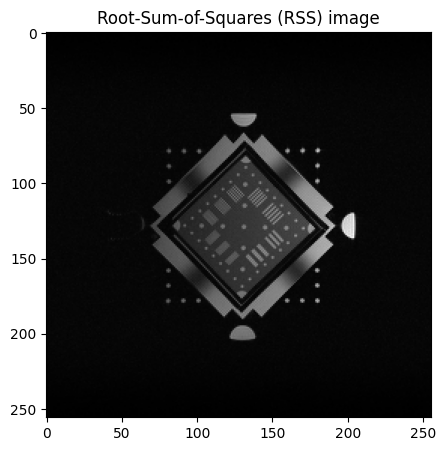

In [3]:
#@title Visualize the original fully-sampled 2D GRE k-space and recon images
import os
from google.colab import files

# Original fully-sampled 2D GRE k-space data. Nx = Ny = 256. ncoil = 18.
gre2d_rawdata = loadmat('gre2d_rawdata.mat')
kspace = gre2d_rawdata['gre2d_rawdata']
Nx = kspace.shape[0]
Ny = kspace.shape[1]
ncoil = kspace.shape[2]
ksp = 1e6*kspace[:,:,np.newaxis,:]
ksp = cfl.writecfl('ksp', ksp)

# Reconstruct k-space using FFT
!bart fft -u -i $(bart bitmask 0 1) ksp im

# Display original fully-sampled k-space
!bart slice 3 0 ksp ksp_coil0
imshow_log('ksp_coil0')
plt.title('Original fully-sampled k-space (coil #0)')

# Slice out one coil-image of the reconstructed k-space phantom and display.
!bart slice 3 0 im im_coil0
imshow('im_coil0')
plt.title('Recon image (coil #0)')

# Combine all coils (Root-Sum-of-Squares)
!bart rss $(bart bitmask 3) im im_rss
imshow('im_rss')
plt.title('Root-Sum-of-Squares (RSS) image')

Type: complex float
Dimensions: 16
AoD:	256	256	1	18	1	1	1	1	1	1	1	1	1	1	1	1
Type: complex float
Dimensions: 16
AoD:	256	256	1	18	1	1	1	1	1	1	1	1	1	1	1	1


<ipython-input-2-4a14dafcaa2e>:20: RuntimeWarning: divide by zero encountered in log
  plt.imshow(np.log(np.abs(x_array)),cmap='gray')


Text(0.5, 1.0, 'reference scan (coil #0)')

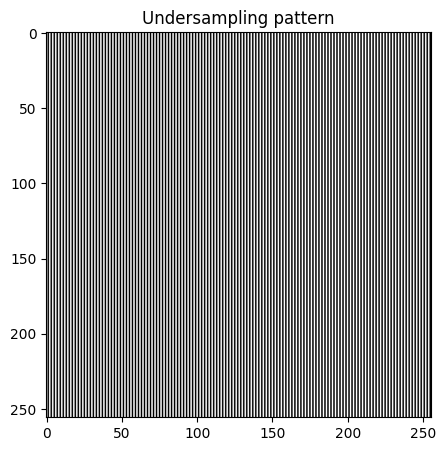

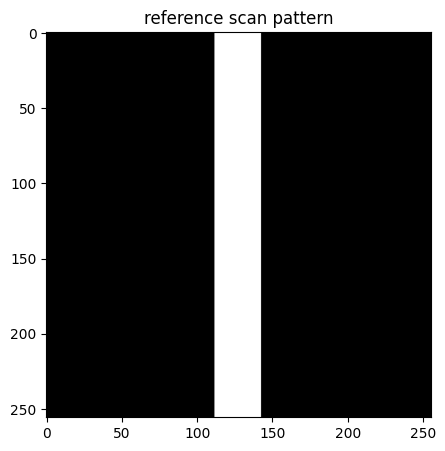

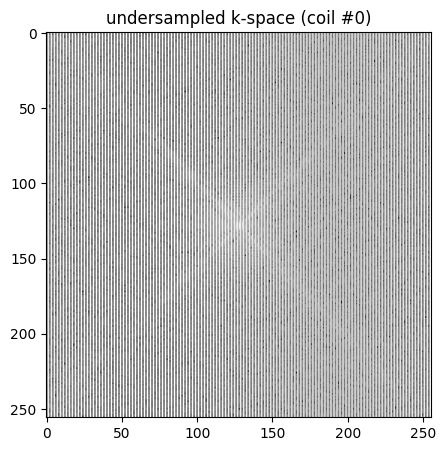

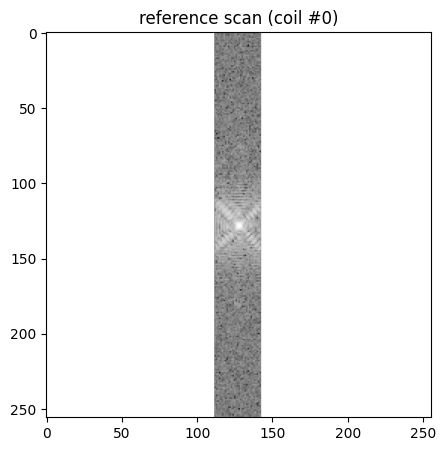

In [4]:
#@title Perform retrospecive undersampling

# Create Cartesian undersampling pattern (2-fold undersampling with 32 auto-calibration lines)
mask_us = np.zeros((Nx, Ny))
mask_ref = np.zeros((Nx, Ny))

mask_us[:, 0::2] = 1
mask_ref[:, 112:143] = 1

cfl.writecfl('mask_us', mask_us)
cfl.writecfl('mask_ref', mask_ref)

# Show pattern
imshow('mask_us')
plt.title('Undersampling pattern')
imshow('mask_ref')
plt.title('reference scan pattern')

# generate undersampled kspace and reference kspace
!bart fmac ksp mask_us ksp_us
!bart fmac ksp mask_ref ksp_ref
!bart show -m ksp_us
!bart show -m ksp_ref
# Display original fully-sampled k-space
!bart slice 3 0 ksp_us ksp_us_coil0
imshow_log('ksp_us_coil0')
plt.title('undersampled k-space (coil #0)')


# Display original fully-sampled k-space
!bart slice 3 0 ksp_ref ksp_ref_coil0
imshow_log('ksp_ref_coil0')
plt.title('reference scan (coil #0)')


## Plot and observe the reference scan kspace and recon images
Plot the k-space of the reference scan and observe that only the centeral region is sampled. Also notice that the frequency encode direction is fully sampled and in the phase encode we only have samples in the central region.



<ipython-input-5-362f0aa19fad>:6: RuntimeWarning: divide by zero encountered in log
  ax.imshow(np.log(np.abs(ksp_ref_array[:,:,:,i*6+index])),cmap='gray')


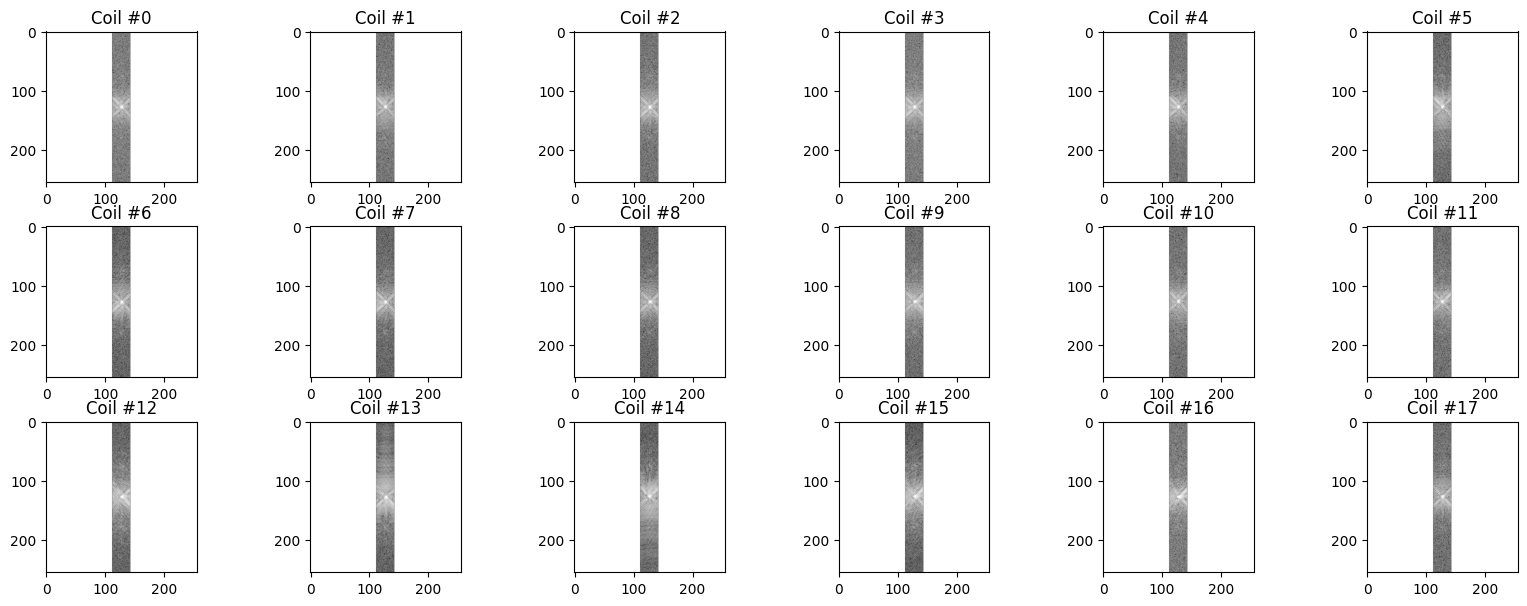

In [5]:
fig, axes = plt.subplots(3, 6, figsize=(16, 6))
ksp_ref_array = cfl.readcfl('ksp_ref')
plt.tight_layout() # This automatically puts space between plots and make it tidy
for i in range(3):
    for ax, index in zip(axes[i], range(ncoil)):
        ax.imshow(np.log(np.abs(ksp_ref_array[:,:,:,i*6+index])),cmap='gray')
        ax.set_title('Coil #{}'.format(i*6 + index))

Now we will perform a linear Fourier reconstruction of reference scan.

Use the `bart fft` tool to do a 2D unitary inverse Fourier transform. Assign the output to `cimg_ref`.

In [6]:
# ifft of the reference scan k-space data
!bart fft -u -i $(bart bitmask 0 1) ksp_ref cimg_ref
###
!bart show -m cimg_ref

Type: complex float
Dimensions: 16
AoD:	256	256	1	18	1	1	1	1	1	1	1	1	1	1	1	1


Plot the calibration images, and observe the low resolution in these images.

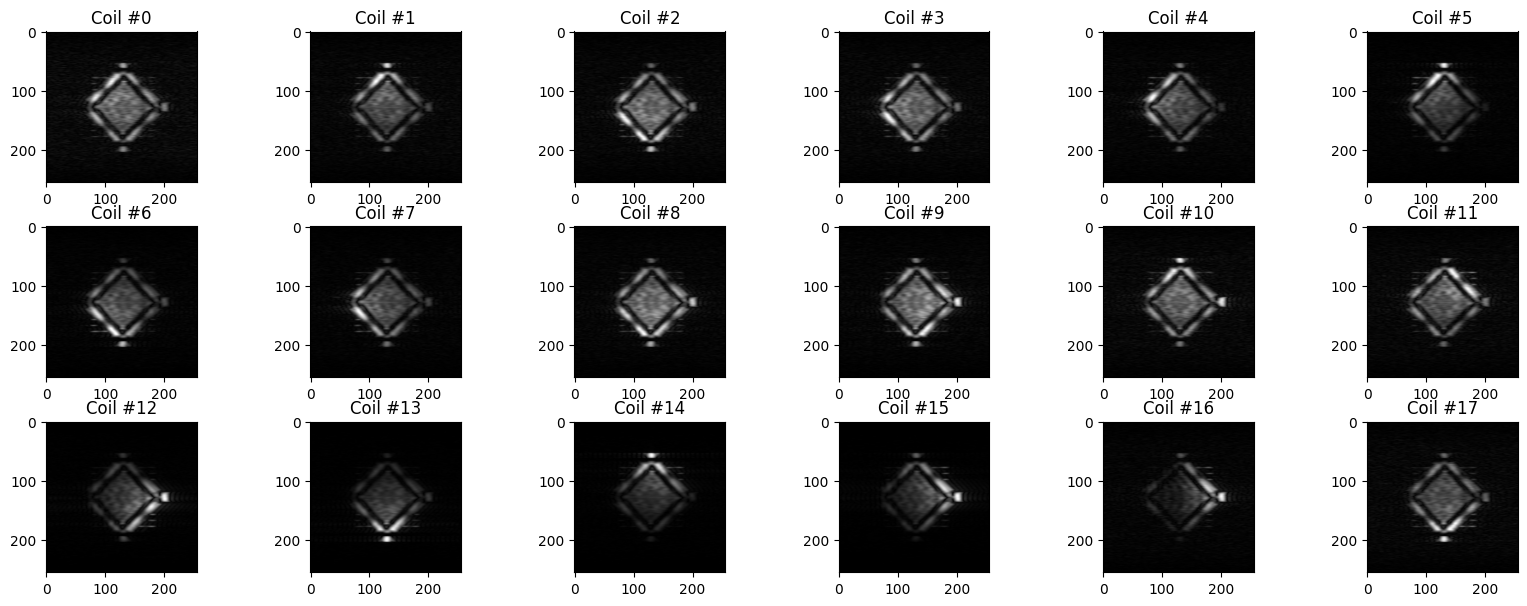

In [7]:
# visualize the reference scan coil images
cimg_ref_array = cfl.readcfl('cimg_ref')
fig, axes = plt.subplots(3, 6, figsize=(16, 6))
plt.tight_layout() # This automatically puts space between plots and make it tidy
for i in range(3):
    for ax, index in zip(axes[i], range(ncoil)):
        ax.imshow(np.abs(cimg_ref_array[:,:,:,i*6+index]),cmap='gray')
        ax.set_title('Coil #{}'.format(i*6 + index))

Now use the `bart rss` tool to perform root-of-sum-of-squares reconstruction along the coil dimension. Call the output `rss_ref`.

Plot the result and observe the low-resolution in the phase-encode direction.

Type: complex float
Dimensions: 16
AoD:	256	256	1	1	1	1	1	1	1	1	1	1	1	1	1	1


Text(0.5, 1.0, 'Reference scan (root of sum of squares)')

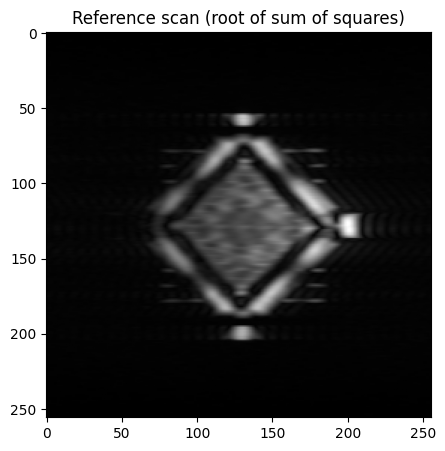

In [8]:
!bart rss $(bart bitmask 3) cimg_ref rss_ref
!bart show -m rss_ref
# visualize the reference scan RSS image
imshow('rss_ref')
plt.title('Reference scan (root of sum of squares)')

##Plot and observe the under-sampled k-space data and recon images
Now we will look at the under-sampled k-space data.

<ipython-input-9-c2e1444e4c39>:6: RuntimeWarning: divide by zero encountered in log
  ax.imshow(np.log(np.abs(ksp_us_array[:,:,:,i*6+index])),cmap='gray')


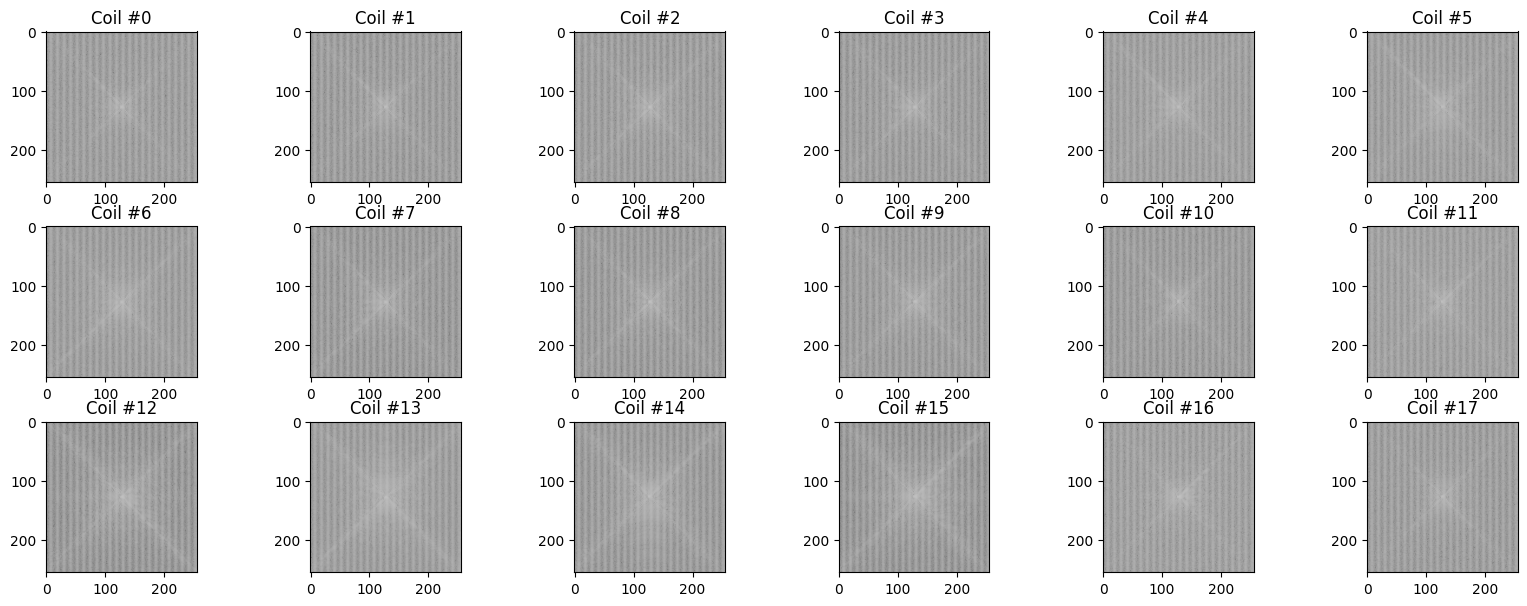

In [9]:
fig, axes = plt.subplots(3, 6, figsize=(16, 6))
ksp_us_array = cfl.readcfl('ksp_us')
plt.tight_layout() # This automatically puts space between plots and make it tidy
for i in range(3):
    for ax, index in zip(axes[i], range(ncoil)):
        ax.imshow(np.log(np.abs(ksp_us_array[:,:,:,i*6+index])),cmap='gray')
        ax.set_title('Coil #{}'.format(i*6 + index))

Visualize the under-sampled data in the image domain.    
Perform a linear Fourier reconstruction of the under-sampled k-space data, following similar steps to those of the reference scan.

In [10]:
# take IFFT of the under-sampled k-space data
!bart fft -u -i $(bart bitmask 0 1) ksp_us cimg_us
###
!bart show -m cimg_us

Type: complex float
Dimensions: 16
AoD:	256	256	1	18	1	1	1	1	1	1	1	1	1	1	1	1


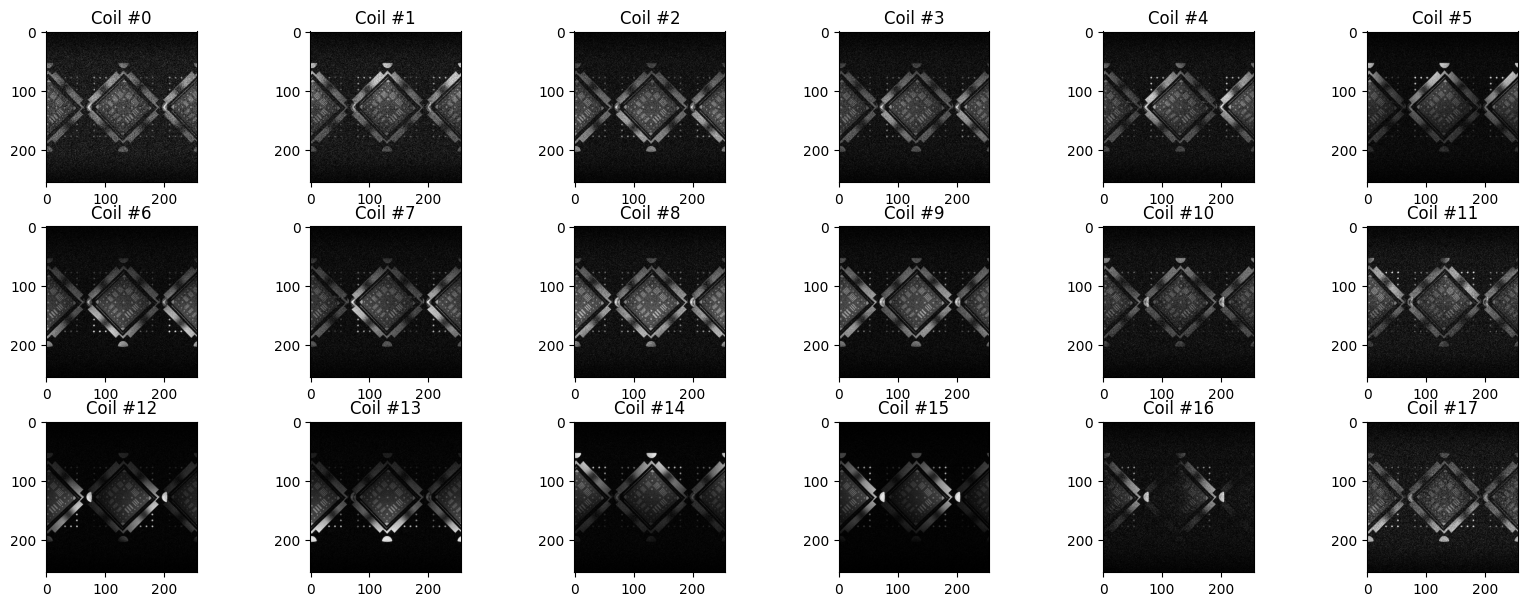

In [11]:
# visualize the undersampled coil images
cimg_us_array = cfl.readcfl('cimg_us')
fig, axes = plt.subplots(3, 6, figsize=(16, 6))
plt.tight_layout() # This automatically puts space between plots and make it tidy
for i in range(3):
    for ax, index in zip(axes[i], range(ncoil)):
        ax.imshow(np.abs(cimg_us_array[:,:,:,i*6+index]), cmap='gray')
        ax.set_title('Coil #{}'.format(i*6 + index))

Perform an RSS reconstruction of the undersampled coil images and plot it. You can observe the high-resolution aliased image of the phantom.

Type: complex float
Dimensions: 16
AoD:	256	256	1	1	1	1	1	1	1	1	1	1	1	1	1	1


Text(0.5, 1.0, 'Undersampled image (root of sum of squares)')

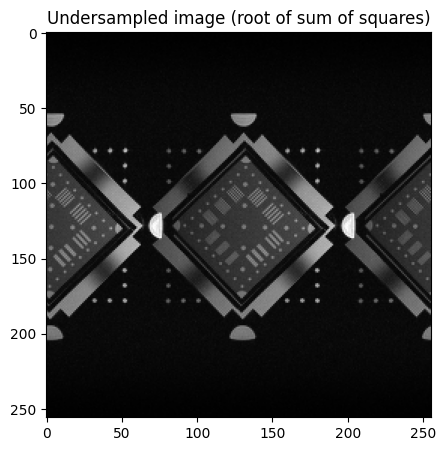

In [12]:
!bart rss $(bart bitmask 3) cimg_us rss_us
!bart show -m rss_us
# visualize the undersampled RSS image
imshow('rss_us')
plt.title('Undersampled image (root of sum of squares)')

##Calculate PICS scale factor
The parallel imaging and compressed sensing, `bart pics` command typically scales the k-space data so that the RSS image has maximum value close to one. This is so that the regularization factor is more consistent across different input datasets.

The scale factor is chosen based on the RSS reconstruction of a fully sampled auto-calibration region in the data:

scale_factor = np.percentile(abs(rss_acs), 99)
where `np.percentile` selects the 99th percentile and `rss_acs` is the RSS reconstruction.

When the input data do not contain a fully sampled calibration region, the `pics` command will not be able to automatically compute the scale factor and it will default to 1.0. Therefore, it is useful to manually calculate the scale factor and pass it to the `pics` command through the `-w` option.

In [13]:
# get the scale factor from the reference data
rss_ref_array = cfl.readcfl('rss_ref')
scale_factor = np.percentile(abs(rss_ref_array), 99)
print('Scale factor: {:.5f}'.format(scale_factor))

Scale factor: 89.77589


##Coil Compression
Before reconstucting, we will coil-compress the coils using the Software Coil Compression method.
First calculate the coil compression matrix using `bart cc` command on the reference scan data. Call the coil compression matrix `cc_matrix`.

Then project the reference scan and the under-sampled k-space data using `bart ccapply` command to the desired number of virtual coils (we recommend about 8) for this data. Call the outputs based on what's shown in the cells.

To see more information about any of these commands use `!bart cc -h` in a new cell.

In [14]:
# run coil compression to get coil compression matrix
!bart cc -M ksp_ref cc_matrix
print('cc_matrix:')
!bart show -m cc_matrix
# apply coil compression to 8  virtual coils -- apply to both the reference scan and the undersampled kspace data
!bart ccapply -p 8 ksp_ref cc_matrix ksp_ref_cc
!bart ccapply -p 8 ksp_us cc_matrix ksp_us_cc

print('ksp_cc_ref:')
!bart show -m ksp_ref_cc
print('ksp_cc_us:')
!bart show -m ksp_us_cc

Done.
cc_matrix:
Type: complex float
Dimensions: 16
AoD:	1	1	1	18	18	1	1	1	1	1	1	1	1	1	1	1
Done.
Done.
ksp_cc_ref:
Type: complex float
Dimensions: 16
AoD:	256	256	1	8	1	1	1	1	1	1	1	1	1	1	1	1
ksp_cc_us:
Type: complex float
Dimensions: 16
AoD:	256	256	1	8	1	1	1	1	1	1	1	1	1	1	1	1


##Coil sensitvity map calibration
Use `bart ecalib` command to estimate the coil sensitivities from the coil-compressed reference scan k-space data and plot the coil sensitivity maps.   
You can use the `-a` parameter to automatically estimate the ESPIRiT parameters. Call the output `coil_sens`.      
See more information: `!bart ecalib -h`

In [15]:
# Compute sensitivity maps using ESPIRiT (constrained to a single map)
# change the DEBUG_LEVEL for this command to reduce the output
!DEBUG_LEVEL=1 bart ecalib -a -m 1 ksp_ref_cc coil_sens
!bart show -m coil_sens

Done.
Type: complex float
Dimensions: 16
AoD:	256	256	1	8	1	1	1	1	1	1	1	1	1	1	1	1


Text(0.5, 1.0, 'Estimated sensitivity maps with auto-ESPIRiT (8 virtual coils)')

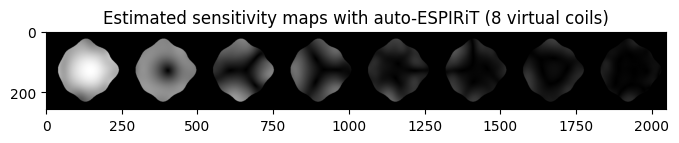

In [16]:
# visualize the estimated coil sensitivities
!bart reshape $(bart bitmask 1 3) 2048 1 coil_sens coil_sens_flat
imshow('coil_sens_flat')
plt.title('Estimated sensitivity maps with auto-ESPIRiT (8 virtual coils)')

##Parallel-imaging compressed-sensing reconstruction (PICS)
Reconstruct the coil-compressed data using the `bart pics` command. First, run the help command and observe which flags you will require for regularization options, manual scaling/re-scaling of the data, and input order.

Plot the reconstructed image and observe that the aliasing is removed and you can see a high-resolution image of the phantom.        
`-R Q:1e-4` is to use L2 regularization with a regularization factor of 1e-4.     
see more information: `!bart pics -h`

Text(0.5, 1.0, 'Reconstruction with l2 regularization')

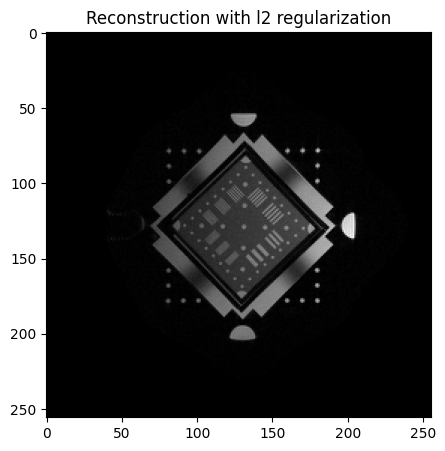

In [17]:
# PICS reconstruction using l2 regularization
!DEBUG_LEVEL=1 bart pics -w 90 -R Q:1e-4 -S ksp_us_cc coil_sens im_us_cc_l2

# Show reconstruction using l2 regularization
imshow('im_us_cc_l2')
plt.title('Reconstruction with l2 regularization')

we can also run `pics` using
L1-norm regularization in a wavelet domain, where the wavelet sparsity transform is applied along the spatial (i.e., 1st, 2nd) dimensions.
`W:$(bart bitmask 0 1):0:<l1wav_reg>` -> wavelet regularization over dims 1 and 2 (typically image dimensions).     
`-S` -> SENSE model (using sensitivity maps)

Size: 65536 Samples: 32767 Acc: 2.00
l1-wavelet regularization: 0.000010
Regularization terms: 1, Supporting variables: 0
FISTA
Total Time: 0.998558


Text(0.5, 1.0, 'Reconstruction using L1 Wavelet Regularization')

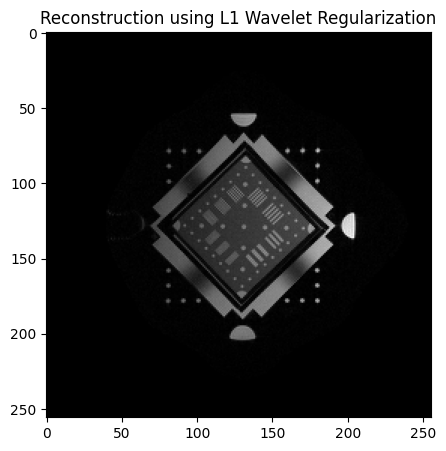

In [18]:
l1wav_reg=1e-5

# Parallel Imaging Compressed Sensing reconstruction using WAVELET sparsity regularization
!bart pics -w 90 -S -R W:$(bart bitmask 0 1):0:$l1wav_reg ksp_us_cc coil_sens ksp_us_cc_wavelet

# Show Wavelet reconstructions
imshow('ksp_us_cc_wavelet')
plt.title("Reconstruction using L1 Wavelet Regularization")